In [1]:
import torch
import os
import sys
import copy
import numpy as np
import random

from functools import cache

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm_notebook

In [3]:
import scipy.optimize
import matplotlib as mpl

from csaps import csaps
from scipy.interpolate import splrep, BSpline

In [4]:
import pygwalker as pyg

In [5]:
os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:8"

In [6]:
os.environ["CUBLAS_WORKSPACE_CONFIG"]

':4096:8'

In [7]:
os.environ['NUMEXPR_MAX_THREADS'] = '16'

In [8]:
rand = 0
torch.manual_seed(rand)
torch.cuda.manual_seed(rand)
torch.cuda.manual_seed_all(rand)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(rand)
random.seed(rand)

In [9]:
def seed_everything(seed: int):
    r"""Sets the seed for generating random numbers in :pytorch:`PyTorch`,
    :obj:`numpy` and Python.

    Args:
        seed (int): The desired seed.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [10]:
import pandas as pd

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
import matplotlib.pyplot as plt
# plt.style.use('fivethirtyeight')

In [13]:
import numpy as np
import networkx as nx

In [14]:
from torch_scatter import scatter_max, scatter_mean, scatter_min
from functools import lru_cache
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.linear_model import ElasticNet, LinearRegression

In [15]:
import wandb

In [16]:
device = "cuda:0"

In [17]:
%load_ext autoreload
%autoreload 2

In [18]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [19]:
from src.cv import crossvalidation, build_masks
from src.trainer import trainer
from src.cv import reset_model
from src.graph_construction import graph
from src.model import NullModel, CustomGAT

In [20]:
import matplotlib as mpl
import seaborn as sns

mpl.rc('image', cmap='Set1')

In [21]:
import torch_geometric.transforms as T
transform = T.Compose([T.ToUndirected(), T.AddSelfLoops()])

In [22]:
torch.use_deterministic_algorithms(True)
seed_everything(rand)

In [23]:
results_dir = os.path.join('results','e27')
os.makedirs(results_dir, exist_ok=True)

config = {
    "custom_optimizer": torch.optim.Adam,
    "lr" : 0.05,
    'epochs': 500,
    'linear_layers': 2,
    'hidden_channels': 8,
    'dropout': 0.1,
    'test_percent': 12,
    'building_buffer': 50,
    'building_buffer_min':20,
    'building_buffer_max':500,
    'building_buffer_npoints':20,
    'neighbor_radius': 100,
    'n_cv': 5,
    'n_cv_generalization':5,
    'cv_size': 1500,
    'graph_outchannels': 8,
    'graph_layers':1,
    'graph_heads':1,
    'partition_terms': [
        "road_area",
        "building_area",
        "sky_area",
        "vegetation_area",
        # "car_count",
        # "person_count"
    ]
}

In [24]:
config['partition_terms']

['road_area', 'building_area', 'sky_area', 'vegetation_area']

In [25]:
f = open(os.path.join(results_dir, 'config_settings.txt'), "w")
f.write(str("Config:\n"))
f.write(str(config))
f.close()

In [26]:
def pool_adjacency(graph, graph_auxillary):
    """Pools environmental features from the region for their use with regression"""
    # energy = scatter_mean(graph['footprint'].y, torch.tensor(graph_auxillary['rebuild_idx']).to(device))
    energy = graph['footprint'].y.detach().cpu()
    links = graph['footprint','contains','pano']['edge_index'].detach().cpu()
    
    panodata = graph['pano'].x.detach().cpu()
    link_source = panodata[links[1]]
    link_sink = links[0]
    features = scatter_mean(link_source, link_sink, dim=0)
    features_max = scatter_max(link_source, link_sink, dim=0)[0]
    features_min = scatter_min(link_source, link_sink, dim=0)[0]
    
    featurenames = graph_auxillary['node_data'].columns
    featuremin = featurenames + '_min'
    featuremax = featurenames + '_max'
    
    featuresdf = pd.DataFrame(panodata, columns = featurenames)
    featuresdfmax = pd.DataFrame(features_max, columns = featuremax)
    featuresdfmin = pd.DataFrame(features_min, columns = featuremin)
    return graph_auxillary['footprints'].join(featuresdf).join(featuresdfmax).join(featuresdfmin)

In [27]:
g1, g1a = graph("new-york", **config)
g1p = pool_adjacency(g1, g1a)

In [28]:
{ **config, **{"normalization":g1a["normalization"]} }

{'custom_optimizer': torch.optim.adam.Adam,
 'lr': 0.05,
 'epochs': 500,
 'linear_layers': 2,
 'hidden_channels': 8,
 'dropout': 0.1,
 'test_percent': 12,
 'building_buffer': 50,
 'building_buffer_min': 20,
 'building_buffer_max': 500,
 'building_buffer_npoints': 20,
 'neighbor_radius': 100,
 'n_cv': 5,
 'n_cv_generalization': 5,
 'cv_size': 1500,
 'graph_outchannels': 8,
 'graph_layers': 1,
 'graph_heads': 1,
 'partition_terms': ['road_area',
  'building_area',
  'sky_area',
  'vegetation_area'],
 'normalization': {'node': (tensor([0.3248, 0.1555, 0.2400, 0.0668], device='cuda:0'),
   tensor([0.1256, 0.1019, 0.0944, 0.0926], device='cuda:0')),
  'building': (tensor([   8.8731, 2789.0620, 4786.8970], device='cuda:0', dtype=torch.float64),
   tensor([  0.7685, 571.0966, 564.8499], device='cuda:0', dtype=torch.float64))}}

In [29]:
g2, g2a = graph("san-francisco", **{ **config, **{"normalization":g1a["normalization"]} })
g2p = pool_adjacency(g2, g2a)

In [30]:
g3, g3a = graph("austin", **{ **config, **{"normalization":g1a["normalization"]} })
g3p = pool_adjacency(g3, g3a)

<AxesSubplot: >

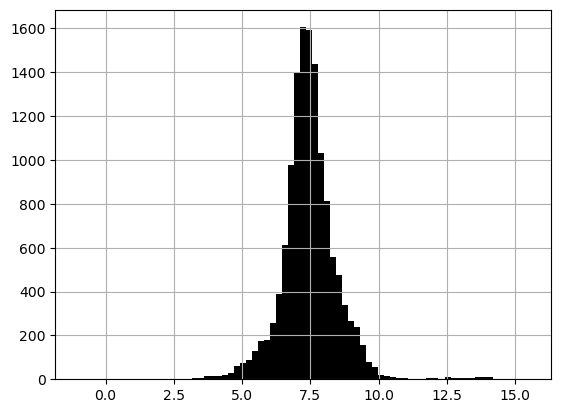

In [31]:
np.log(g1a['footprints'].energy).hist(bins=75, color="black")

In [32]:
g1p.drop(columns=["id","geometry","year"]).describe()

,energy,area,hdd,cdd,road_area,building_area,sky_area,vegetation_area,road_area_max,building_area_max,sky_area_max,vegetation_area_max,road_area_min,building_area_min,sky_area_min,vegetation_area_min
count,1.325000e+04,13250.000000,13250.000000,13250.000000,13250.000000,13250.000000,13250.000000,13250.000000,13250.000000,13250.000000,13250.000000,13250.000000,13250.000000,13250.000000,13250.000000,13250.000000
mean,9.262743e+03,9721.956829,2789.061976,4786.897043,-0.034267,0.208520,-0.164041,-0.047283,0.669876,1.006933,0.666637,1.678859,-1.706769,-1.186220,-1.411939,-0.682195
std,1.176355e+05,8862.209154,571.096633,564.849908,1.009208,1.044116,0.935870,0.960546,0.249633,0.920242,0.710793,1.387557,1.224673,0.534737,0.932753,0.219886
min,3.597384e-01,27.870939,185.345664,2183.403795,-2.586608,-1.526968,-2.539475,-0.721965,-2.586608,-1.526968,-2.530580,-0.721965,-2.586608,-1.526968,-2.541275,-0.721965
25%,1.041417e+03,4180.640846,2480.251137,4422.924014,0.020160,-0.494681,-0.740728,-0.721965,0.514820,0.371210,0.176104,0.494772,-2.586608,-1.526968,-2.256012,-0.721965
50%,1.668340e+03,6573.128699,2923.467476,4791.827975,0.287745,0.169573,-0.119350,-0.453037,0.719638,0.921295,0.708165,1.686721,-2.586608,-1.526968,-1.559163,-0.721965
75%,2.873830e+03,11550.088722,3183.698351,5156.940276,0.553856,0.859768,0.485165,0.231298,0.840830,1.581524,1.196680,2.855099,-0.130692,-0.903821,-0.788510,-0.721965
max,5.376747e+06,50304.071944,4149.092892,7351.370592,1.258868,4.125157,2.426675,4.832312,1.905673,4.757753,2.610391,5.938804,0.999605,2.664613,2.351283,4.042053


In [33]:
with pd.option_context('display.float_format', '{:,.2f}'.format):
    print(g1p.drop(columns=["id","geometry","year"]).describe())

            energy      area       hdd       cdd  road_area  building_area  \
count    13,250.00 13,250.00 13,250.00 13,250.00  13,250.00      13,250.00   
mean      9,262.74  9,721.96  2,789.06  4,786.90      -0.03           0.21   
std     117,635.48  8,862.21    571.10    564.85       1.01           1.04   
min           0.36     27.87    185.35  2,183.40      -2.59          -1.53   
25%       1,041.42  4,180.64  2,480.25  4,422.92       0.02          -0.49   
50%       1,668.34  6,573.13  2,923.47  4,791.83       0.29           0.17   
75%       2,873.83 11,550.09  3,183.70  5,156.94       0.55           0.86   
max   5,376,747.40 50,304.07  4,149.09  7,351.37       1.26           4.13   

       sky_area  vegetation_area  road_area_max  building_area_max  \
count 13,250.00        13,250.00      13,250.00          13,250.00   
mean      -0.16            -0.05           0.67               1.01   
std        0.94             0.96           0.25               0.92   
min       -2.54  

In [34]:
# from src.graph_construction import graph
# g1, g1a = graph(
#     "new-york",
#     neighbor_radius=config['neighbor_radius'],
#     building_buffer=config['building_buffer'],
#     test_percent=config['test-percent']
# )
# trainids, testids = build_corpus(g1, g1a)

# # nycgraph = transform(nycgraph)

In [35]:
idpool = g1a['footprints'].id
idtrain = idpool[g1a['training_mask'].detach().cpu().numpy()]
idtest = idpool[g1a['test_mask'].detach().cpu().numpy()]

### at this point, starting to train the model based on the new york data. m1 will be the linear model with no auxillary features, m2 will be the remote sensing data, m3 will be the comprehensive data

In [36]:
f = open(os.path.join(results_dir, 'config_settings.txt'), "a")
f.write(str("\n\n"))
f.write(str("NY Graph:\n"))
f.write(str(g1))
f.close()

In [37]:
def build_corpus(graphobj, graphdata):
    trainids = []
    testids = []

    training_corpus = pool_adjacency(graphobj, graphdata).iloc[graphdata['training_mask'].detach().cpu().numpy()].reset_index(drop=True)

    kf = KFold(n_splits=config['n_cv'], random_state=rand, shuffle=True)
    for train, test in kf.split(training_corpus):
        trainids.append(training_corpus.id[train])
        testids.append(training_corpus.id[test])
        
    return trainids, testids

In [38]:
def custom_cv(model, training_corpus, trainids, testids):
    """This needs to implement cross validation but only using hte set which is found in the first radius search of the building"""
    losses = []
    abslosses = []
    totalhashsum = 0
    for c,i in enumerate(trainids):
        custom_model = copy.deepcopy(model)
        training = training_corpus.loc[training_corpus.id.isin(i)]
        testing = training_corpus.loc[training_corpus.id.isin(testids[c])]
        
        hashsum = int(pd.util.hash_pandas_object(training.id).sum()) % 1000
        totalhashsum += hashsum
                
        X = np.array(training.drop(columns=["id","geometry","energy","year"]))
        y = np.array(training["energy"])
        custom_model.fit(X,y)
        
        Xt = np.array(testing.drop(columns=["id","geometry","energy","year"]))
        yt = np.array(testing["energy"])
        yhat = custom_model.predict(Xt)
        
        # in this case, the Y term is already not normalized
        losses.append(np.power(((yhat - yt)**2).mean(axis=None), 0.5))
        abslosses.append(np.abs(yhat - yt).mean(axis=None))
        
    print(f"Total Hashsum: {totalhashsum}")
    return (losses, abslosses)

In [ ]:
distances = np.logspace(
    np.log10(config['building_buffer_min']), 
    np.log10(config['building_buffer_max']), 
    config['building_buffer_npoints']
)

In [ ]:
# print(f"N Training: {len(trainids[0])}\nN Testing: {len(testids[0])}")

In [ ]:
# print(f"Losses:\n\nM1: {m1_rmse:,.2f}\nM2: {m2_rmse:,.2f}\nM3: {m3_rmse:,.2f}")

In [ ]:
# print(f"Losses:\n\nM4: {m4_rmse:,.2f}\nM5: {m5_rmse:,.2f}\nM6: {m6_rmse:,.2f}")

In [ ]:
# np.mean(losses) / 1e6

In [ ]:
# np.mean(abslosses)

In [ ]:
# from src.graph_construction import graph
# sfgraph, sf_rebuild_info = graph(
#     "san-fransisco",
#     neighbor_radius=config['neighbor_radius'],
#     building_buffer=config['building_buffer'],
#     test_percent=config['test-percent']
# )

In [ ]:
f = open(os.path.join(results_dir, 'config_settings.txt'), "a")
f.write(str("\n\n"))
f.write(str("San Fransisco Graph:\n"))
f.write(str(g2))
f.close()

In [ ]:
# from src.graph_construction import graph
# austingraph, austin_rebuild_info = graph(
#     "austin",
#     neighbor_radius=config['neighbor_radius'],
#     building_buffer=config['building_buffer'],
#     test_percent=config['test-percent']
# )

In [ ]:
f = open(os.path.join(results_dir, 'config_settings.txt'), "a")
f.write(str("\n\n"))
f.write(str("Austin Graph:\n"))
f.write(str(g3))
f.close()

In [ ]:
(~g1a['training_mask']).sum()

In [ ]:
g1a['training_mask'].sum()

In [ ]:
# loss_func = torch.nn.MSELoss()

In [ ]:
lossing_func = torch.nn.MSELoss()

In [ ]:
loss_func = lambda x,y: lossing_func(torch.exp(x), torch.exp(y))

In [ ]:
loss_func

In [ ]:
nyc_mask = g1a['training_mask'].cpu().numpy()

In [ ]:
int(nyc_mask.sum() * 0.1)

In [ ]:
config['cv_size'] = int(nyc_mask.sum() * 0.1)
config['cv_size']

In [ ]:
config

In [ ]:
seed_everything(rand)
nyc_cvs = build_masks(nyc_mask, **config)
nyc_cvs

In [ ]:
valmean = []
valstd = []

trainmean = []
trainstd = []

nyX = g1['footprint'].x.detach().cpu().numpy()
nyY = g1['footprint'].y.cpu()

cvtrain_errors = []
cv_errors = []
for crossfold in nyc_cvs:
    nytrain, nyval = crossfold

    linearmodel = ElasticNet()
    reg = linearmodel.fit(nyX[nytrain], nyY[nytrain])
    overfitpred = reg.predict(nyX[nytrain])
    fitpred = reg.predict(nyX[nyval])

    # these terms are all normalized, so this should be projected back with exp
    overfitloss = float(loss_func(torch.tensor(overfitpred), nyY[nytrain]))
    regloss = float(loss_func(torch.tensor(fitpred), nyY[nyval]))

    cvtrain_errors.append(overfitloss)
    cv_errors.append(regloss)

linear_regtrainerr = np.mean(cvtrain_errors)
linear_regerr = np.mean(cv_errors)

trainmean.append(linear_regtrainerr)
valmean.append(linear_regerr)

trainstd.append(np.std(cvtrain_errors))
valstd.append(np.std(cv_errors))

In [ ]:
nyY

In [ ]:
plt.figure(dpi=125)

plt.plot(range(len(cv_errors)), cv_errors, '-o', label="Validate")
plt.plot(range(len(cvtrain_errors)), cvtrain_errors, '-o', label="Training")
plt.legend()
plt.show()

In [ ]:
trainmean

In [ ]:
valmean

In [ ]:
linearmodel = ElasticNet()
fullreg = linearmodel.fit(nyX, nyY)

In [ ]:
# plt.plot(range(ntesting), trainmean, label="training")
# plt.fill_between(
#     range(ntesting), 
#     np.array(trainmean) - np.array(trainstd), 
#     np.array(trainmean) + np.array(trainstd),
#     alpha=0.2
# ) 

# plt.plot(range(ntesting), valmean, label="validation")
# plt.fill_between(
#     range(ntesting), 
#     np.array(valmean) - np.array(valstd), 
#     np.array(valmean) + np.array(valstd),
#     alpha=0.2
# )

# plt.ylim(0.3, 1.3)
# plt.legend()
# plt.show()

In [ ]:
# config['epochs'] = int(1e3)
# config['lr'] = 0.01

In [ ]:
config

In [ ]:
g1['footprint'].x

In [ ]:
g1['pano']

In [ ]:
# from collections import Counter
# sorted(Counter(g1a['footprints'].id).items(), key=lambda x:-x[1])

In [ ]:
g1a['footprints'].drop(columns=["id","geometry","year"])

In [ ]:
g1a['node_data_original'].columns

In [ ]:
g1a['footprints'].energy

In [ ]:
config['input_shape'] = g1['footprint'].x.shape[1]

In [ ]:
g1a['footprints']

In [ ]:
# input_shape = nycgraph['footprint'].x.shape[1]
seed_everything(rand)

nullmodel = NullModel(
    layers = config['linear_layers'],
    input_shape = config['input_shape'],
    hidden_channels = config['hidden_channels']
).to(device)

default_nullmodelstate = copy.deepcopy(nullmodel.state_dict())
null_training_tensor, null_validation_tensor = crossvalidation(
    nullmodel,
    lambda: nullmodel(g1['footprint'].x),
    nyc_cvs,
    g1['footprint'].y,
    epochs = config['epochs'],
    custom_optimizer = config['custom_optimizer'],
    lr = config['lr'],
    config = config,
    log_model = False
)

In [ ]:
model = CustomGAT(
    hidden_channels = config['hidden_channels'], 
    out_channels=config['graph_outchannels'],
    layers=config['graph_layers'],
    heads=config['graph_heads'],
    linear_layers = config['linear_layers'],
    input_shape = config['input_shape'],
    dropout = config['dropout']
).to(device)

default_modelstate = copy.deepcopy(model.state_dict())

In [ ]:
crossvalidation?

In [ ]:
loss_func

In [ ]:
seed_everything(rand)
graph_training_tensor, graph_validation_tensor = crossvalidation(
    model,
    lambda: model(g1.x_dict, g1.edge_index_dict),
    nyc_cvs,
    g1['footprint'].y,
    epochs = config['epochs'],
    custom_optimizer = config['custom_optimizer'],
    lr = config['lr'],
    config = config,
    loss_func = loss_func,
    log_model = False
)

In [ ]:
g1a['footprints'].describe()

In [ ]:
# g1a['footprints'].explore('energy', control_scale=True)

In [ ]:
null_mean_tl = null_training_tensor.mean(axis=0)
null_mean_vl = null_validation_tensor.mean(axis=0)
nulllower_vl = np.percentile(null_validation_tensor, 5, axis=0)
nullupper_vl = np.percentile(null_validation_tensor, 95, axis=0)

In [ ]:
mean_tl = graph_training_tensor.mean(axis=0)
std_tl = graph_training_tensor.std(axis=0)

mean_vl = graph_validation_tensor.mean(axis=0)
lower_vl = np.percentile(graph_validation_tensor, 5, axis=0)
upper_vl = np.percentile(graph_validation_tensor, 95, axis=0)
std_vl = graph_validation_tensor.std(axis=0)

# plt.plot(mean_tl, label="Graph Training")
# plt.plot(mean_vl, label="Graph Validation")
# plt.legend()

# plt.yscale("log")
# plt.ylim((0.55,0.65))

# plt.show()

In [ ]:
mean_vl[:5]

In [ ]:
graph_epochs = np.argmin(mean_vl)
deepl_epochs = np.argmin(null_mean_vl)

In [ ]:
domain = np.arange(0, config['epochs'])
plt.figure(figsize=(6, 6), dpi=100)

# plt.plot(domain, mean_tl, label="Training")
plt.plot(domain, mean_vl, label="Validation", color="lightblue")
plt.fill_between(domain, upper_vl, lower_vl, alpha=0.1)

# plt.plot(domain, null_mean_tl, label="Null Training", color="indianred", linestyle='dashed')
plt.plot(domain, null_mean_vl, label="Null Validation", color="salmon", linestyle='dashed')
plt.fill_between(domain, nullupper_vl, nulllower_vl, alpha=0.1)

plt.hlines(valmean[0], min(domain), max(domain), color='pink', label="linear regression")

plt.title(f"Loss Function with Training - lr: {config['lr']}")

plt.xlabel("Epoch")
plt.ylabel("Training Loss - MSE")
plt.legend()

# plt.yscale("log")
plt.ylim((0.4,1.2))

plt.savefig(os.path.join(results_dir, 'model_comparison.png'), bbox_inches="tight")
plt.show()

In [ ]:
graph_improvement = (min(mean_vl) - min(null_mean_vl)) / min(null_mean_vl)
print("Improvement from Context: {:0.2f}%".format(100*graph_improvement))

In [ ]:
np.min(mean_vl)

In [ ]:
np.percentile(mean_vl, 5)

In [ ]:
f = open(os.path.join(results_dir, 'results_summary.txt'), "w")
f.write(str("New York City Profile:\n"))
f.write(str("Min CV Loss:\t{:.4f}\n".format(np.min(mean_vl))))
f.write(str("5th P CV Loss:\t{:.4f}\n".format(np.percentile(mean_vl, 5))))
f.write(str("25th P CV Loss:\t{:.4f}\n\n".format(np.percentile(mean_vl, 25))))
f.close()

In [ ]:
## In understanding how the model generalizes, we look at the lowest validation systems
nullmodel.load_state_dict(default_nullmodelstate)
nullmodel.to(device)
nullmodel.train()
    
model.load_state_dict(default_modelstate)
model.to(device)
model.train()

null_training_tensor, null_validation_tensor = crossvalidation(
    nullmodel,
    lambda: nullmodel(g1['footprint'].x),
    [nyc_cvs[0]],
    g1['footprint'].y,
    epochs = deepl_epochs,
    custom_optimizer = config['custom_optimizer'],
    lr = config['lr'],
    config = config,
    log_model = False
)

graph_training_tensor, graph_validation_tensor = crossvalidation(
    model,
    lambda: model(g1.x_dict, g1.edge_index_dict),
    [nyc_cvs[0]],
    g1['footprint'].y,
    epochs = graph_epochs,
    custom_optimizer = config['custom_optimizer'],
    lr = config['lr'],
    config = config,
    log_model = False
)

In [ ]:
# now examining how this may generalize
model.eval()
nullmodel.eval()
with torch.no_grad():
    print("New York City")
    testidx = (~g1a['training_mask']).detach().cpu().numpy()
    # rebuilding_idx = np.array(g1a['rebuild_idx'])

    linear_predictions = reg.predict(g1['footprint'].x.cpu().numpy())[testidx]
    null_predictions = nullmodel(g1['footprint'].x).squeeze()[testidx]
    estimates = model(g1.x_dict, g1.edge_index_dict).squeeze().detach()[testidx]
    recorded = g1['footprint'].y[testidx]

    linear_loss = loss_func(torch.tensor(linear_predictions).to(device), recorded)
    null_loss = loss_func(null_predictions, recorded)
    graph_loss = loss_func(estimates, recorded)
    
    print("Linear Loss:\t{:0.3f}".format(linear_loss))
    print("Null Loss:\t{:0.3f}".format(null_loss))
    print("Graph Loss:\t{:0.3f}".format(graph_loss))
    print("Improvement:\t{:0.3f}".format(100 * (graph_loss - null_loss)/null_loss))

In [ ]:
f = open(os.path.join(results_dir, 'results_summary.txt'), "a")
f.write(str("New York City Test Set Results:\n"))

f.write(("Linear Loss:\t{:0.3f}\n".format(linear_loss)))
f.write(("Null Loss:\t\t{:0.3f}\n".format(null_loss)))
f.write(("Graph Loss:\t\t{:0.3f}\n".format(graph_loss)))
f.write(("Percent Ben:\t{:0.3f}\n\n".format(100 * (graph_loss - null_loss)/null_loss)))

f.close()

In [ ]:
linmae = torch.abs(torch.exp(recorded) - torch.tensor(np.exp(linear_predictions)).to(device))
nullmae = torch.abs(torch.exp(recorded) - torch.exp(null_predictions))
graphmae = torch.abs(torch.exp(recorded) - torch.exp(estimates))

In [ ]:
def relative_benefit(errors, threshold):
    return float(100 * ((errors <= threshold).sum() / len(errors)))

In [ ]:
### want to get a curve to show accuracy with various buffers
linmae_list = []
nullmae_list = []
graphmae_list = []

maxlenlist = 2000

for i in range(maxlenlist):
    linmae_list.append(relative_benefit(linmae, i))
    nullmae_list.append(relative_benefit(nullmae, i))
    graphmae_list.append(relative_benefit(graphmae, i))

In [ ]:
plt.figure(dpi=150)

plt.plot(range(maxlenlist), linmae_list, label="Linear")
plt.plot(range(maxlenlist), nullmae_list, label="Null")
plt.plot(range(maxlenlist), graphmae_list, label="Graph")

# plt.yscale("log")
plt.ylim(0,100)
plt.xlim(0,maxlenlist)

plt.xlabel("Acceptable Threshold of Success - MWH")
plt.ylabel("% of Accurate Predictions")

plt.legend()

plt.savefig(os.path.join(results_dir, "accurate_predictions_nyc.png"), transparent=True, bbox_inches="tight")

plt.show()

In [ ]:
plt.figure(dpi=150)

plt.plot(range(maxlenlist), np.array(graphmae_list) - np.array(nullmae_list), '-', label="Benefit Delta - Null")
plt.plot(range(maxlenlist), np.array(graphmae_list) - np.array(linmae_list), '-', label="Graph")

plt.hlines(0, xmin = 0, xmax = maxlenlist, color="pink", alpha=0.5)

# plt.yscale("log")
# plt.ylim(0,20)
plt.xlim(0,maxlenlist)

plt.ylabel("Relative MAE Benefit to Linear Model")
plt.xlabel("MWH Threshold")

plt.title("MAE Accuracy Benefit Relative to Linear")
plt.savefig(os.path.join(results_dir, "relative_benefit.png"), transparent=True, bbox_inches="tight")
plt.legend()

plt.show()

In [ ]:
threshold = 500

print(f"Linear Benefit:\t\t{relative_benefit(linmae, threshold):0.2f}")
print(f"Null Benefit:\t\t{relative_benefit(nullmae, threshold):0.2f}")
print(f"Graph Benefit:\t\t{relative_benefit(graphmae, threshold):0.2f}")

In [ ]:
tcorp = pool_adjacency(g1, g1a).reset_index(drop=True)
# tcorp

In [ ]:
RandomForestRegressor(max_depth=3, random_state=rand)

In [ ]:
g1, g1a = graph("new-york", **{**config, **{"building_buffer":config['building_buffer_min']}})
trainids, testids = build_corpus(g1, g1a)

In [ ]:
pd.util.hash_pandas_object(tcorp.id).sum()

In [ ]:
tcorp = pool_adjacency(g1, g1a).reset_index(drop=True)

In [ ]:
m1_terms = ["id","geometry","energy","year","area"]
tcorp[m1_terms]

In [ ]:
## this is now the segment where we explore the utility of various datasets with increasing distance from the model
m1a = []
m2a = []
m3a = []
m4a = []
m5a = []
m6a = []

m1l = []
m2l = []
m3l = []
m4l = []
m5l = []
m6l = []

linearmodel = ElasticNet()
tree = RandomForestRegressor(max_depth = 3, min_samples_leaf=10, n_estimators = 500, random_state = rand, n_jobs = -1)

# starting graph, which defines the test and train ids
g1, g1a = graph("new-york", **{**config, **{"building_buffer":config['building_buffer_min']}})
trainids, testids = build_corpus(g1, g1a)

for distance in tqdm_notebook(distances):
    print(f"\nDistance: {distance:.2f}")
    g1, g1a = graph("new-york", **{**config, **{"building_buffer":distance}})
    tcorp = pool_adjacency(g1, g1a).reset_index(drop=True)
    
    m1_terms = ["id","geometry","energy","year","area"]
    losses, abslosses = custom_cv(linearmodel, tcorp[m1_terms], trainids, testids)
    m1_rmse = np.mean(losses)
    m1_mae = np.mean(abslosses)
    m1a.append(m1_mae)
    m1l.append(m1_rmse)

    m2_terms = ["id","geometry","energy","year","area","hdd","cdd"]
    losses, abslosses = custom_cv(linearmodel, tcorp[m2_terms], trainids, testids)
    m2_rmse = np.mean(losses)
    m2_mae = np.mean(abslosses)
    m2a.append(m2_mae)
    m2l.append(m2_rmse)

    m3_terms = m2_terms + config['partition_terms'] + [ x+'_max' for x in config['partition_terms']] + [ x+'_min' for x in config['partition_terms'] ]
    losses, abslosses = custom_cv(linearmodel, tcorp[m3_terms], trainids, testids)
    m3_rmse = np.mean(losses)
    m3_mae = np.mean(abslosses)
    m3a.append(m3_mae)
    m3l.append(m3_rmse)

    m4_terms = m1_terms
    tree = RandomForestRegressor(max_depth = 3, min_samples_leaf=10, n_estimators = 500, random_state = rand, n_jobs = -1)
    losses, abslosses = custom_cv(tree, tcorp[m4_terms], trainids, testids)
    m4_rmse = np.mean(losses)
    m4_mae = np.mean(abslosses)
    m4a.append(m4_mae)
    m4l.append(m4_rmse)

    m5_terms = m2_terms
    tree = RandomForestRegressor(max_depth = 3, min_samples_leaf=10, n_estimators = 500, random_state = rand, n_jobs = -1)
    losserandom_state, abslosses = custom_cv(tree, tcorp[m5_terms], trainids, testids)
    m5_rmse = np.mean(losses)
    m5_mae = np.mean(abslosses)
    m5a.append(m5_mae)
    m5l.append(m5_rmse)

    m6_terms = m3_terms
    tree = RandomForestRegressor(max_depth = 3, min_samples_leaf=10, n_estimators = 500, random_state = rand, n_jobs = -1)
    losses, abslosses = custom_cv(tree, tcorp[m6_terms], trainids, testids)
    m6_rmse = np.mean(losses)
    m6_mae = np.mean(abslosses)
    m6a.append(m6_mae)
    m6l.append(m6_rmse)

In [ ]:
n1a = []
n2a = []
n3a = []

n1l = []
n2l = []
n3l = []

# starting graph, which defines the test and train ids
g2, g2a = graph("san-francisco", **{**config, **{"building_buffer":config['building_buffer_min']}})
trainids, testids = build_corpus(g2, g2a)

for distance in tqdm_notebook(distances):
    g2, g2a = graph("san-francisco", **{**config, **{"building_buffer":distance}})
    tcorp = pool_adjacency(g2, g2a).reset_index(drop=True)
    
    m1_terms = ["id","geometry","energy","year","area"]
    losses, abslosses = custom_cv(linearmodel, tcorp[m1_terms], trainids, testids)
    m1_rmse = np.mean(losses)
    m1_mae = np.mean(abslosses)
    n1a.append(m1_mae)
    n1l.append(m1_rmse)

    m2_terms = ["id","geometry","energy","year","area","hdd","cdd"]
    losses, abslosses = custom_cv(linearmodel, tcorp[m2_terms], trainids, testids)
    m2_rmse = np.mean(losses)
    m2_mae = np.mean(abslosses)
    n2a.append(m2_mae)
    n2l.append(m2_rmse)

    m3_terms = m2_terms + config['partition_terms'] + [ x+'_max' for x in config['partition_terms']] + [ x+'_min' for x in config['partition_terms'] ]
    losses, abslosses = custom_cv(linearmodel, tcorp[m3_terms], trainids, testids)
    m3_rmse = np.mean(losses)
    m3_mae = np.mean(abslosses)
    n3a.append(m3_mae)
    n3l.append(m3_rmse)

In [ ]:
linearmodel

In [ ]:
o1a = []
o2a = []
o3a = []

o1l = []
o2l = []
o3l = []

# starting graph, which defines the test and train ids
g3, g3a = graph("austin", **{**config, **{"building_buffer":config['building_buffer_min']}})
trainids, testids = build_corpus(g3, g3a)

for distance in tqdm_notebook(distances):
    g3, g3a = graph("austin", **{**config, **{"building_buffer":distance}})
    tcorp = pool_adjacency(g3, g3a).reset_index(drop=True)
    
    m1_terms = ["id","geometry","energy","year","area"]
    losses, abslosses = custom_cv(linearmodel, tcorp[m1_terms], trainids, testids)
    m1_rmse = np.mean(losses)
    m1_mae = np.mean(abslosses)
    o1a.append(m1_mae)
    o1l.append(m1_rmse)

    m2_terms = ["id","geometry","energy","year","area","hdd","cdd"]
    losses, abslosses = custom_cv(linearmodel, tcorp[m2_terms], trainids, testids)
    m2_rmse = np.mean(losses)
    m2_mae = np.mean(abslosses)
    o2a.append(m2_mae)
    o2l.append(m2_rmse)

    m3_terms = m2_terms + config['partition_terms'] + [ x+'_max' for x in config['partition_terms']] + [ x+'_min' for x in config['partition_terms'] ]
    losses, abslosses = custom_cv(linearmodel, tcorp[m3_terms], trainids, testids)
    m3_rmse = np.mean(losses)
    m3_mae = np.mean(abslosses)
    o3a.append(m3_mae)
    o3l.append(m3_rmse)

In [ ]:
def parabola(x, a, b, c, d):
    return a*x**3 + b*x**2 + c*x + d

In [ ]:
fit_params, pcov = scipy.optimize.curve_fit(parabola, distances, m3l)
y_fit = parabola(distances, *fit_params)

In [ ]:
# plt.scatter(training_corpus
s = 0.0001
# m1s = splrep(distances, np.array(m1l), s=s)
# m2s = splrep(distances, np.array(m2l), s=s)
# m3s = splrep(distances, np.array(m3l), s=s)
# m4s = splrep(distances, np.array(m4l), s=s)
# m5s = splrep(distances, np.array(m5l), s=s)
# m6s = splrep(distances, np.array(m6l), s=s)
# Create subplots with shared x-axis

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, dpi=300, figsize=(8,15))
fig.patch.set_facecolor('white')

ax1.set_facecolor('white')
ax2.set_facecolor('white')
ax3.set_facecolor('white')

# ax.set_color_cycle(sns.color_palette("coolwarm_r",6))

alpha = 0.2

# plt.scatter(distances, m4l, alpha=alpha)
# plt.scatter(distances, m5l, alpha=alpha)
# plt.scatter(distances, m6l, alpha=alpha)

newdist = np.linspace(distances[0], distances[-1], 300)
fit_params, pcov = scipy.optimize.curve_fit(parabola, distances, m3a)
m_fit = parabola(newdist, *fit_params)

nfit_params, pcov = scipy.optimize.curve_fit(parabola, distances, n3a)
n_fit = parabola(newdist, *nfit_params)

ofit_params, pcov = scipy.optimize.curve_fit(parabola, distances, o3a)
o_fit = parabola(newdist, *ofit_params)

ax1.set_title("Building Buffer vs. MAE - New York City")
ax1.scatter(distances, m1a, alpha=0)
ax1.scatter(distances, m2a, alpha=0)
ax1.scatter(distances, m3a, alpha=alpha)

ax1.plot(newdist, csaps(distances, m1a, newdist, smooth=s), label="M1")
ax1.plot(newdist, csaps(distances, m2a, newdist, smooth=s), label="M2")
ax1.plot(newdist, m_fit, label="M3")

ax1.set_ylabel('MAE')

ax2.scatter(distances, n1a, alpha=0)
ax2.scatter(distances, n2a, alpha=0)
ax2.scatter(distances, n3a, alpha=alpha)

ax2.plot(newdist, csaps(distances, n1a, newdist, smooth=s), label="M1")
ax2.plot(newdist, csaps(distances, n2a, newdist, smooth=s), label="M2")
ax2.plot(newdist, n_fit, label="M3")

ax2.set_ylabel('MAE')

ax3.scatter(distances, o1a, alpha=0)
ax3.scatter(distances, o2a, alpha=0)
ax3.scatter(distances, o3a, alpha=alpha)

ax3.plot(newdist, csaps(distances, o1a, newdist, smooth=s), label="M1")
ax3.plot(newdist, csaps(distances, o2a, newdist, smooth=s), label="M2")
ax3.plot(newdist, o_fit, label="M3")

ax3.set_ylabel('MAE')

# plt.plot(newdist, csaps(distances, m4l, newdist, smooth=s), label="M4")
# plt.plot(newdist, csaps(distances, m5l, newdist, smooth=s), label="M5")
# plt.plot(newdist, csaps(distances, m6l, newdist, smooth=s), label="M6")

ax3.set_xlabel("Building Buffer (m)")

# plt.title("Building Buffer vs. RMSE - New York City")
# plt.ticklabel_format(axis='y', style='sci', scilimits=(4,4))
plt.xticks(np.linspace(distances.min(), distances.max(), 8))

ax1.legend(loc="upper right")

ax1.set_title('New York City')
ax2.set_title('San Francisco')
ax3.set_title('Austin')

plt.savefig(os.path.join(results_dir, "contextual_significance.png"), transparent=True, bbox_inches="tight")
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(8,5), dpi=400)
fig.patch.set_facecolor('white')

ax.set_facecolor('white')
# plt.plot(domain, mean_tl, label="Training")
plt.plot(domain, mean_vl, label="Validation", color="lightblue")
# plt.fill_between(domain, mean_vl + std_vl, mean_vl - std_vl, alpha=0.1)

# plt.plot(domain, null_mean_tl, label="Null Training", color="indianred", linestyle='dashed')
plt.plot(domain, null_mean_vl, label="Null Validation", color="salmon", linestyle='dashed')

plt.hlines(valmean[0], min(domain), max(domain), color='pink', label="Linear Regression")

plt.title(f"Loss Function with Training - lr: {config['lr']}")

plt.xlabel("Epoch")
plt.ylabel("Training Loss - MSE")
plt.legend()

# plt.yscale("log")
plt.ylim((0.5,1.2))

plt.savefig(os.path.join(results_dir, 'model_comparison.png'), bbox_inches="tight", transparent=True)
plt.show()

In [ ]:
# plt.scatter(training_corpus

s = 0.0005
# m1s = splrep(distances, np.array(m1l), s=s)
# m2s = splrep(distances, np.array(m2l), s=s)
# m3s = splrep(distances, np.array(m3l), s=s)
# m4s = splrep(distances, np.array(m4l), s=s)
# m5s = splrep(distances, np.array(m5l), s=s)
# m6s = splrep(distances, np.array(m6l), s=s)

fig, ax = plt.subplots(figsize=(8,5), dpi=400)
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# plt.yscale("log")

alpha = 0.2

plt.scatter(distances, m1a, alpha=alpha)
plt.scatter(distances, m2a, alpha=alpha)
plt.scatter(distances, m3a, alpha=alpha)
plt.scatter(distances, m4a, alpha=alpha)
plt.scatter(distances, m5a, alpha=alpha)
plt.scatter(distances, m6a, alpha=alpha)

newdist = np.linspace(distances[0], distances[-1], 300)
plt.plot(newdist, csaps(distances, m1a, newdist, smooth=s), label="M1")
plt.plot(newdist, csaps(distances, m2a, newdist, smooth=s), label="M2")
plt.plot(newdist, csaps(distances, m3a, newdist, smooth=s), label="M3")
plt.plot(newdist, csaps(distances, m4a, newdist, smooth=s), label="M4")
plt.plot(newdist, csaps(distances, m5a, newdist, smooth=s), label="M5")
plt.plot(newdist, csaps(distances, m6a, newdist, smooth=s), label="M6")

plt.ylabel("MAE")
plt.xlabel("Building Buffer (m)")

plt.title("Building Buffer vs. MAE - New York City")
plt.ticklabel_format(axis='y', style='sci', scilimits=(2,4))
plt.xticks(np.linspace(distances.min(), distances.max(), 8))

plt.legend(loc="upper right")
plt.savefig(os.path.join(results_dir, "contextual_significance_mae.png"))
plt.show()

In [ ]:
nycfootprints = g1a['footprints']
nycfootprints['logenergy'] = np.log(nycfootprints.energy)

# nycfootprints.explore('logenergy')

In [ ]:
torch.exp(null_predictions)

In [ ]:
testidx = (~g2a['training_mask']).detach().cpu().numpy()
testidx

In [ ]:
rebuilding_idx = np.array(g2a['rebuild_idx'])

In [ ]:
g1a['footprints']

In [ ]:
config

In [ ]:
g1, g1a = graph("new-york", **config)
g1a['footprints']['logenergy'] = np.log(g1a['footprints'].energy)

g1p = pool_adjacency(g1, g1a)

In [ ]:
## building these using generalization parameters from New York
g2, g2a = graph("san-francisco", **{**config, **{"normalization": g1a["normalization"]}})
g2a['footprints']['logenergy'] = np.log(g2a['footprints'].energy)
g2p = pool_adjacency(g2, g2a)

g3, g3a = graph("austin", **{**config, **{"normalization": g1a["normalization"]}})
g3a['footprints']['logenergy'] = np.log(g3a['footprints'].energy)
g3p = pool_adjacency(g3, g3a)

In [ ]:
g1a.keys()

In [ ]:
g1a['footprints'].logenergy

In [ ]:
g1a['footprints']

In [ ]:
config

In [ ]:
## first want to load each of the models which will be trained on the entire dataset from the other city
nullmodel.load_state_dict(default_nullmodelstate)
nullmodel.to(device)
nullmodel.train()
    
model.load_state_dict(default_modelstate)
model.to(device)
model.train()

nulloptimizer = torch.optim.Adam(nullmodel.parameters(), lr = config['lr'])
optimizer = torch.optim.Adam(model.parameters(), lr = config['lr'])

# maybe I want to take the 5th percentile of minimum validation loss actually
set_epochs = config['epochs']

for epoch in tqdm_notebook(range(set_epochs), desc="Model Epoch", leave=False):
    loss = 0
    validation_loss = 0

    out = model(g1.x_dict, g1.edge_index_dict)
    out_ex = out.squeeze()

    training_predictions = out_ex.to(torch.float).to(device)
    training_values = torch.tensor(g1a['footprints'].logenergy).to(torch.float).to(device)

    loss = loss_func(
        training_predictions,
        training_values
    ).to(torch.float)
    
    if epoch % 100 == 0:
        print("{} loss: {}".format(epoch, loss))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
print("")
for epoch in tqdm_notebook(range(set_epochs), desc="NullModel Epoch", leave=False):
    loss = 0
    validation_loss = 0

    out = nullmodel(g1['footprint'].x)
    out_ex = out.squeeze()

    training_predictions = out_ex.to(torch.float).to(device)
    training_values = torch.tensor(g1a['footprints'].logenergy).to(torch.float).to(device)

    loss = loss_func(
        training_predictions,
        training_values
    ).to(torch.float)
    
    if epoch % 100 == 0:
        print("{} loss: {}".format(epoch, loss))

    nulloptimizer.zero_grad()
    loss.backward()
    nulloptimizer.step()
    
nystate_dict = model.state_dict()
nullnystate_dict = nullmodel.state_dict()

# training = training_corpus.loc[training_corpus.id.isin(i)]
# testing = training_corpus.loc[training_corpus.id.isin(testids[c])]

# X = np.array(training.drop(columns=["id","geometry","energy","year"]))
# y = np.array(training["energy"])
# custom_model.fit(X,y)

# Xt = np.array(testing.drop(columns=["id","geometry","energy","year"]))
# yt = np.array(testing["energy"])
# yhat = custom_model.predict(Xt)

In [ ]:
g2['footprint'].y

In [ ]:
# now examining how this may generalize
model.eval()
nullmodel.eval()

with torch.no_grad():
    print("San Francisco")
    testidx = (~g2a['training_mask']).detach().cpu().numpy()
    rebuilding_idx = np.array(g2a['rebuild_idx'])
    null_predictions = nullmodel(g2['footprint'].x).squeeze()[testidx]
    
    linear_predictions = reg.predict(g2['footprint'].x.cpu().numpy())[testidx]
    estimates = model(g2.x_dict, g2.edge_index_dict).squeeze().detach()[testidx]
    recorded = g2['footprint'].y[testidx]

    linear_loss = loss_func(torch.tensor(linear_predictions).to(device), recorded)
    null_loss = loss_func(null_predictions, recorded)
    graph_loss = loss_func(estimates, recorded)
    print("Linear Loss:\t{:0.2f}".format(linear_loss))
    print("Null Loss:\t{:0.2f}".format(null_loss))
    print("Graph Loss:\t{:0.2f}".format(graph_loss))
    print("Improvement:\t{:0.2f}".format(100 * (graph_loss - null_loss)/null_loss))

In [ ]:
f = open(os.path.join(results_dir, 'results_summary.txt'), "a")
f.write(str("San Francisco Test Set Results - No Finetuning:\n"))

f.write(("Linear Loss:\t{:0.3f}\n".format(linear_loss)))
f.write(("Null Loss:\t\t{:0.3f}\n".format(null_loss)))
f.write(("Graph Loss:\t\t{:0.3f}\n".format(graph_loss)))
f.write(("Percent Ben:\t{:0.3f}\n\n".format(100 * (graph_loss - null_loss)/null_loss)))

f.close()

In [ ]:
nullmodel.eval()
model.eval()
with torch.no_grad():
    print("Austin Texas")
    testidx = (~g3a['training_mask']).detach().cpu().numpy()
    rebuilding_idx = np.array(g3a['rebuild_idx'])
    null_predictions = nullmodel(g3['footprint'].x).squeeze()[testidx]
    
    linear_predictions = reg.predict(g3['footprint'].x.cpu().numpy())[testidx]
    
    estimates = model(g3.x_dict, g3.edge_index_dict).squeeze().detach()[testidx]
    recorded = g3['footprint'].y[testidx]
    
    linear_loss = loss_func(torch.tensor(linear_predictions).to(device), recorded)
    null_loss = loss_func(null_predictions, recorded)
    graph_loss = loss_func(estimates, recorded)
    print("Linear Loss:\t{:0.2f}".format(linear_loss))
    print("Null Loss:\t{:0.2f}".format(null_loss))
    print("Graph Loss:\t{:0.2f}".format(graph_loss))
    print("Improvement:\t{:0.2f}".format(100 * (graph_loss - null_loss)/null_loss))

In [ ]:
f = open(os.path.join(results_dir, 'results_summary.txt'), "a")
f.write(str("Austin Test Set Results - No Finetuning:\n"))

f.write(("Linear Loss:\t{:0.3f}\n".format(linear_loss)))
f.write(("Null Loss:\t\t{:0.3f}\n".format(null_loss)))
f.write(("Graph Loss:\t\t{:0.3f}\n".format(graph_loss)))
f.write(("Percent Ben:\t{:0.3f}\n\n".format(100 * (graph_loss - null_loss)/null_loss)))

f.close()

In [ ]:
optim = config['custom_optimizer']
optim(model.parameters())

In [ ]:
### I used the below cells to evaluate how many epochs to use for the final model

In [ ]:


# model.load_state_dict(default_modelstate)
# model.train()

# trainmask = nyc_rebuild_info['training_mask']
# testmask = (~nyc_rebuild_info['training_mask'])

# rebuild_idx = np.array(nyc_rebuild_info['rebuild_idx'])

# nystate_dict_origin, trainlosses, testlosses = trainer(
#     model.to(device),
#     lambda: model(nycgraph.x_dict, nycgraph.edge_index_dict),
#     rebuild_idx,
#     trainmask[rebuild_idx],
#     testmask[rebuild_idx],
#     recorded = nycgraph['footprint'].y,
#     loss_func = loss_func,
#     config = config
# )

# nystate_dict = copy.deepcopy(nystate_dict_origin)

In [ ]:
# from src.trainer import trainer
# from src.cv import reset_model

# nullmodel.load_state_dict(default_nullmodelstate)

# trainmask = nyc_rebuild_info['training_mask']
# testmask = (~nyc_rebuild_info['training_mask'])

# rebuild_idx = np.array(nyc_rebuild_info['rebuild_idx'])

# nystate_dict_origin, trainlosses, testlosses = trainer(
#     nullmodel.to(device),
#     lambda: nullmodel(nycgraph['footprint'].x),
#     rebuild_idx,
#     trainmask[rebuild_idx],
#     testmask[rebuild_idx],
#     recorded = nycgraph['footprint'].y,
#     loss_func = loss_func,
#     config = config
# )

# nynull_state_dict = copy.deepcopy(nystate_dict_origin)

In [ ]:
# plt.plot(trainlosses, label="training")
# plt.plot(testlosses, label="testing")

# plt.legend()
# plt.yscale("log")

# plt.show()

In [ ]:
# # this is manually set based on the above graph^
# from src.trainer import trainer

# model.load_state_dict(default_modelstate)

# trainmask = nyc_rebuild_info['training_mask']
# testmask = (~nyc_rebuild_info['training_mask'])

# trainmask = np.repeat([True], len(trainmask))
# rebuild_idx = np.array(nyc_rebuild_info['rebuild_idx'])

# nystate_dict_origin, trainlosses, testlosses = trainer(
#     model.to(device),
#     lambda: model(nycgraph.x_dict, nycgraph.edge_index_dict),
#     rebuild_idx,
#     trainmask[rebuild_idx],
#     testmask[rebuild_idx],
#     recorded = nycgraph['footprint'].y,
#     loss_func = loss_func,
#     config = config,
#     fulldata = True
# )

# nystate_dict = copy.deepcopy(nystate_dict_origin)

In [ ]:
# nullmodel.train()
# nullmodel.load_state_dict(default_nullmodelstate)

# trainmask = nyc_rebuild_info['training_mask']
# testmask = (~nyc_rebuild_info['training_mask'])

# trainmask = np.repeat([True], len(trainmask))
# rebuild_idx = np.array(nyc_rebuild_info['rebuild_idx'])

# nystate_dict_origin, trainlosses, testlosses = trainer(
#     nullmodel.to(device),
#     lambda: nullmodel(nycgraph['footprint'].x),
#     rebuild_idx,
#     trainmask[rebuild_idx],
#     testmask[rebuild_idx],
#     recorded = nycgraph['footprint'].y,
#     loss_func = loss_func,
#     config = config,
#     fulldata = True
# )

# nystate_nulldict = copy.deepcopy(nystate_dict_origin)

In [ ]:
# np.vstack((nyX, sfgraph['footprint'].x[:50].cpu().detach())).shape

In [ ]:
### this is going to be the drip system, to understand how slow incorporation of data changes the prediction quality

In [ ]:
# nyY

In [ ]:
# 150 * 30 * 52 * 40 / 1e6

In [ ]:
# from tqdm import tqdm_notebook

# # now exploring how the model might generalize to SF
# sf_linearvalloss = []

# sf_valloss = []
# sf_nullvalloss = []

# config['epochs'] = 300

# for n_true in tqdm_notebook(range(100), leave=True):
#     model.load_state_dict(nystate_dict)
#     nullmodel.load_state_dict(nullnystate_dict)
    
#     model.train()
#     nullmodel.train()

#     sf_trainmask = copy.deepcopy(g2a['training_mask'])
#     sf_testmask = copy.deepcopy((~g2a['training_mask']))

#     sf_to_false = np.where(sf_trainmask.cpu().numpy())[0]
#     sf_to_false

#     np.random.seed(1)
#     drip_idx = np.random.choice(sf_to_false, n_true, replace=False)

#     # this now just drips in a bit of the sf data
#     sf_trainmask = np.repeat([False], len(sf_trainmask))
#     sf_trainmask[drip_idx] = True

#     rebuild_idx = np.array(g2a['rebuild_idx'])
    
#     # shapes
#     # print(f"trainmask shape: {trainmask.shape}")
    
#     ## building the linear model
#     x_linear_addition = np.vstack((nyX, g2['footprint'].x[sf_trainmask].cpu().detach()))
    
#     # print(f"Y shape: {nyY.shape}.")
#     # print(f"trainyshape: {sfgraph['footprint'].y[trainmask[rebuild_idx]].cpu().detach().shape}")
#     y_linear_addition = np.concatenate((nyY, g2['footprint'].y[sf_trainmask].cpu().detach()), axis=None)
    
#     reg = LinearRegression().fit(x_linear_addition, y_linear_addition)
#     preds = reg.predict(g2['footprint'].x[sf_testmask].cpu().detach())
#     existing_terms = g2['footprint'].y[sf_testmask].cpu().detach()
#     # print(f"Predictions: {preds}")
#     # print(f"Existing: {existing_terms}")
#     sf_linearvalloss.append(loss_func(torch.tensor(preds), existing_terms))

#     sf_state_dict, sf_trainlosses, sf_testlosses = trainer(
#         model.to(device),
#         lambda: model(g2.x_dict, g2.edge_index_dict),
#         rebuild_idx,
#         sf_trainmask,
#         sf_testmask,
#         recorded = g2['footprint'].y,
#         loss_func = loss_func,
#         config = config
#     )
    
#     _, _, sf_nulltestlosses = trainer(
#         nullmodel.to(device),
#         lambda: nullmodel(g2['footprint'].x),
#         rebuild_idx,
#         sf_trainmask,
#         sf_testmask,
#         recorded = g2['footprint'].y,
#         loss_func = loss_func,
#         config = config
#     )
#     sf_valloss.append(sf_testlosses)
#     sf_nullvalloss.append(sf_nulltestlosses)

In [ ]:
generalization_cv = 8
# config['epochs'] = 300

In [ ]:
config['n_cv']

In [ ]:
g2['footprint'].y

In [ ]:
# now exploring how the model might generalize to SF
sf_linearvalloss = []
sf_valloss = []
sf_nullvalloss = []

for n_true in tqdm_notebook(range(100), leave=True):
    modelcv_loss = []
    nullmodelcv_loss = []
    linearcv_loss = []
    
    for cv in range(config['n_cv']):
        seed_everything(rand)
        model.load_state_dict(nystate_dict)
        nullmodel.load_state_dict(nullnystate_dict)
        
        model.train()
        nullmodel.train()

        sf_trainmask = copy.deepcopy(g2a['training_mask'].cpu().numpy())
        np.random.shuffle(sf_trainmask)

        sf_testmask = ~sf_trainmask
        sf_to_false = np.where(sf_trainmask)[0]
        sf_to_false

        drip_idx = np.random.choice(sf_to_false, n_true, replace=False)

        # this now just drips in a bit of the sf data
        sf_trainmask = np.repeat([False], len(sf_trainmask))
        sf_trainmask[drip_idx] = True

        rebuild_idx = np.array(g2a['rebuild_idx'])

        # shapes
        # print(f"trainmask shape: {trainmask.shape}")

        ## building the linear model
        x_linear_addition = np.vstack((nyX, g2['footprint'].x[sf_trainmask].cpu().detach()))

        # print(f"Y shape: {nyY.shape}.")
        # print(f"trainyshape: {sfgraph['footprint'].y[trainmask[rebuild_idx]].cpu().detach().shape}")
        y_linear_addition = np.concatenate((nyY, g2['footprint'].y[sf_trainmask].cpu().detach()), axis=None)

        linearmodel = ElasticNet()
        reg = linearmodel.fit(x_linear_addition, y_linear_addition)
        preds = reg.predict(g2['footprint'].x[sf_testmask].cpu().detach())
        existing_terms = g2['footprint'].y[sf_testmask].cpu().detach()
        # print(f"Predictions: {preds}")
        # print(f"Existing: {existing_terms}")
        linearcv_loss.append(loss_func(torch.tensor(preds), existing_terms))

        sf_state_dict, sf_trainlosses, sf_testlosses = trainer(
            model.to(device),
            lambda: model(g2.x_dict, g2.edge_index_dict),
            rebuild_idx,
            sf_trainmask,
            sf_testmask,
            recorded = g2['footprint'].y,
            loss_func = loss_func,
            config = config
        )

        _, _, sf_nulltestlosses = trainer(
            nullmodel.to(device),
            lambda: nullmodel(g2['footprint'].x),
            rebuild_idx,
            sf_trainmask,
            sf_testmask,
            recorded = g2['footprint'].y,
            loss_func = loss_func,
            config = config
        )
        modelcv_loss.append(sf_testlosses)
        nullmodelcv_loss.append(sf_nulltestlosses)
        
    sf_linearvalloss.append(linearcv_loss)
    sf_valloss.append(modelcv_loss)
    sf_nullvalloss.append(nullmodelcv_loss)
        
sf_linearvalloss = np.array(sf_linearvalloss)
sf_valloss = np.array(sf_valloss)
sf_nullvalloss = np.array(sf_nullvalloss)

In [ ]:
np.percentile(sf_linearvalloss, 5, axis=1)

In [ ]:
np.arange(50)

In [ ]:
sf_linearvalloss.mean(axis=1)[-1]

In [ ]:
sf_nullvalloss.min(axis=2).mean(axis=1)[-1]

In [ ]:
sf_valloss.min(axis=2).mean(axis=1)[-1]

In [ ]:
1 - sf_valloss.min(axis=2).mean(axis=1)[-1] / sf_linearvalloss.mean(axis=1)[-1]

In [ ]:
1 - sf_valloss.min(axis=2).mean(axis=1)[-1] / sf_nullvalloss.min(axis=2).mean(axis=1)[-1]

In [ ]:
# plt.plot(sf_trainlosses, label="training")
plt.figure(figsize=(4, 6), dpi=600)

# plt.plot(sf_linearvalloss, label="Linear", color="coral")
# plt.plot(np.percentile(sf_nullvalloss, 5, axis=1), label="MLP", color="orange")
# plt.plot(np.percentile(sf_valloss, 2, axis=1), label="Graph", color="lightblue")
lower = 5
upper = 95

plt.plot(sf_linearvalloss.mean(axis=1), label="Linear", color="firebrick")
plt.fill_between(
    np.arange(sf_linearvalloss.shape[0]), 
    np.percentile(sf_linearvalloss, lower, axis=1), 
    np.percentile(sf_linearvalloss, upper, axis=1), 
    color="firebrick", 
    alpha=0.1
)

plt.plot(sf_nullvalloss.min(axis=2).mean(axis=1), label="MLP", color="lightsalmon")
plt.fill_between(
    np.arange(sf_nullvalloss.shape[0]), 
    np.percentile(sf_nullvalloss.min(axis=2), lower, axis=1), 
    np.percentile(sf_nullvalloss.min(axis=2), upper, axis=1),
    color="lightsalmon", 
    alpha=0.1
)

plt.plot(sf_valloss.min(axis=2).mean(axis=1), label="Graph", color="lightblue")
plt.fill_between(
    np.arange(sf_valloss.shape[0]), 
    np.percentile(sf_valloss.min(axis=2), lower, axis=1), 
    np.percentile(sf_valloss.min(axis=2), upper, axis=1),
    color="lightblue", 
    alpha=0.1
)

plt.legend(loc='upper right')
# plt.yscale("log")
# plt.xscale("log")

plt.title("Generalization from New York to San Fransisco")
plt.xlabel("# Buildings from San Fransisco")
plt.ylabel("Loss - RMSE")

plt.ylim((0.5,3.5))

plt.savefig(os.path.join(results_dir, 'sf_generalization.png'), bbox_inches="tight")
plt.show()

In [ ]:
g3train = copy.deepcopy((g3a['training_mask']).cpu().numpy())
np.random.shuffle(g3train)

g3test = ~g3train

In [ ]:
config

In [ ]:
# now exploring how the model might generalize to SF
austin_linearvalloss = []
austin_valloss = []
austin_nullvalloss = []

for n_true in tqdm_notebook(range(100), leave=True):
    modelcv_loss = []
    nullmodelcv_loss = []
    linearcv_loss = []
    
    for cv in range(generalization_cv):
        np.random.seed(cv)
        model.load_state_dict(nystate_dict)
        nullmodel.load_state_dict(nullnystate_dict)
        
        model.train()
        nullmodel.train()

        austin_trainmask = copy.deepcopy(g3a['training_mask'].cpu().numpy())
        np.random.shuffle(austin_trainmask)

        austin_testmask = ~austin_trainmask
        austin_to_false = np.where(austin_trainmask)[0]
        austin_to_false

        drip_idx = np.random.choice(austin_to_false, n_true, replace=False)

        # this now just drips in a bit of the sf data
        austin_trainmask = np.repeat([False], len(austin_trainmask))
        austin_trainmask[drip_idx] = True

        rebuild_idx = np.array(g3a['rebuild_idx'])

        # shapes
        # print(f"trainmask shape: {trainmask.shape}")

        ## building the linear model
        x_linear_addition = np.vstack((nyX, g3['footprint'].x[austin_trainmask].cpu().detach()))

        # print(f"Y shape: {nyY.shape}.")
        # print(f"trainyshape: {sfgraph['footprint'].y[trainmask[rebuild_idx]].cpu().detach().shape}")
        y_linear_addition = np.concatenate((nyY, g3['footprint'].y[austin_trainmask].cpu().detach()), axis=None)

        linearmodel = ElasticNet()
        reg = linearmodel.fit(x_linear_addition, y_linear_addition)
        preds = reg.predict(g3['footprint'].x[austin_testmask].cpu().detach())
        existing_terms = g3['footprint'].y[austin_testmask].cpu().detach()
        # print(f"Predictions: {preds}")
        # print(f"Existing: {existing_terms}")
        linearcv_loss.append(loss_func(torch.tensor(preds), existing_terms))

        austin_state_dict, austin_trainlosses, austin_testlosses = trainer(
            model.to(device),
            lambda: model(g3.x_dict, g3.edge_index_dict),
            rebuild_idx,
            austin_trainmask,
            austin_testmask,
            recorded = g3['footprint'].y,
            loss_func = loss_func,
            config = config
        )

        _, _, austin_nulltestlosses = trainer(
            nullmodel.to(device),
            lambda: nullmodel(g3['footprint'].x),
            rebuild_idx,
            austin_trainmask,
            austin_testmask,
            recorded = g3['footprint'].y,
            loss_func = loss_func,
            config = config
        )
        modelcv_loss.append(austin_testlosses)
        nullmodelcv_loss.append(austin_nulltestlosses)
        
    austin_linearvalloss.append(linearcv_loss)
    austin_valloss.append(modelcv_loss)
    austin_nullvalloss.append(nullmodelcv_loss)
        
austin_linearvalloss = np.array(austin_linearvalloss)
austin_valloss = np.array(austin_valloss)
austin_nullvalloss = np.array(austin_nullvalloss)

In [ ]:
g3['footprint'].y

In [ ]:
nyY

In [ ]:
austin_valloss.mean(axis=1).min(axis=0).shape

In [ ]:
austin_nullvalloss.min(axis=2).shape

In [ ]:
austin_linearvalloss.mean(axis=1)[-5:]

In [ ]:
austin_nullvalloss.min(axis=2).mean(axis=1)[-5:]

In [ ]:
austin_valloss.min(axis=2).mean(axis=1)[-5:]

In [ ]:
1 - austin_valloss.min(axis=2).mean(axis=1)[-1] / austin_linearvalloss.mean(axis=1)[-1]

In [ ]:
1 - austin_valloss.min(axis=2).mean(axis=1)[-1] / austin_nullvalloss.min(axis=2).mean(axis=1)[-1]

In [ ]:
austin_linearvalloss.mean(axis=1)[0]

In [ ]:
austin_nullvalloss.min(axis=2).mean(axis=1)[0]

In [ ]:
austin_valloss.min(axis=2).mean(axis=1)[0]

In [ ]:
sampletable = [
    {"Linear":sf_linearvalloss.mean(axis=1)[-1], "MLP":sf_nullvalloss.min(axis=2).mean(axis=1)[-1], "Graph": sf_valloss.min(axis=2).mean(axis=1)[-1]},
    {"Linear":austin_linearvalloss.mean(axis=1)[-1], "MLP":austin_nullvalloss.min(axis=2).mean(axis=1)[-1], "Graph":austin_valloss.min(axis=2).mean(axis=1)[-1]}
]

tabledf = pd.DataFrame(sampletable, index=["San Francisco", "Austin"]).style.format(decimal='.', thousands=',', precision=2)
print(tabledf.to_latex())

In [ ]:
sampletable = [
    {"Linear":sf_linearvalloss.mean(axis=1)[0], "MLP":sf_nullvalloss.min(axis=2).mean(axis=1)[0], "Graph": sf_valloss.min(axis=2).mean(axis=1)[0]},
    {"Linear":austin_linearvalloss.mean(axis=1)[0], "MLP":austin_nullvalloss.min(axis=2).mean(axis=1)[0], "Graph":austin_valloss.min(axis=2).mean(axis=1)[0]}
]

tabledf = pd.DataFrame(sampletable, index=["San Francisco", "Austin"]).style.format(decimal='.', thousands=',', precision=2)
print(tabledf.to_latex())

In [ ]:
plt.hist

In [ ]:
sns.

In [ ]:
colors = ['#E69F00', '#56B4E9', '#F0E442']
names = ["New York City", "San Francisco", "Austin"]

plt.hist([
    g1a['footprints'].energy,
    g2a['footprints'].energy,
    g3a['footprints'].energy
], histtype='stepfilled', bins=100, alpha=0.8, label = names, color = colors)

plt.yscale("log")

plt.legend()
plt.show()

In [ ]:
# plt.plot(sf_trainlosses, label="training")
plt.figure(figsize=(4, 6), dpi=600)

# plt.plot(austin_linearvalloss.mean(axis=1), label="Linear", color="firebrick")
# plt.plot(austin_nullvalloss.min(axis=2).mean(axis=1), label="MLP", color="lightsalmon")
# plt.plot(austin_valloss.min(axis=2).mean(axis=1), label="Graph", color="lightblue")

plt.plot(austin_linearvalloss.mean(axis=1), label="Linear", color="firebrick")
plt.fill_between(
    np.arange(austin_linearvalloss.shape[0]), 
    np.percentile(austin_linearvalloss, lower, axis=1), 
    np.percentile(austin_linearvalloss, upper, axis=1), 
    color="firebrick", 
    alpha=0.1
)

plt.plot(austin_nullvalloss.min(axis=2).mean(axis=1), label="MLP", color="lightsalmon")
plt.fill_between(
    np.arange(austin_nullvalloss.shape[0]), 
    np.percentile(austin_nullvalloss.min(axis=2), lower, axis=1), 
    np.percentile(austin_nullvalloss.min(axis=2), upper, axis=1),
    color="lightsalmon", 
    alpha=0.1
)

plt.plot(austin_valloss.min(axis=2).mean(axis=1), label="Graph", color="lightblue")
plt.fill_between(
    np.arange(austin_valloss.shape[0]), 
    np.percentile(austin_valloss.min(axis=2), lower, axis=1), 
    np.percentile(austin_valloss.min(axis=2), upper, axis=1),
    color="lightblue", 
    alpha=0.1
)

plt.legend(loc='upper right')
# plt.yscale("log")
# plt.xscale("log")

plt.title("Generalization from New York to Austin")
plt.xlabel("# Buildings from Austin")
plt.ylabel("Loss - RMSE")

plt.ylim((0,10))
plt.savefig(os.path.join(results_dir, 'austin_generalization.png'), bbox_inches="tight")

plt.show()

In [ ]:
# plt.plot(sf_trainlosses, label="training")
plt.figure(figsize=(4, 6), dpi=600)

# plt.plot(austin_linearvalloss.mean(axis=1), label="Linear", color="firebrick")
# plt.plot(austin_nullvalloss.min(axis=2).mean(axis=1), label="MLP", color="lightsalmon")
# plt.plot(austin_valloss.min(axis=2).mean(axis=1), label="Graph", color="lightblue")

# plt.plot(austin_linearvalloss.mean(axis=1), label="Linear", color="firebrick")
# plt.fill_between(
#     np.arange(austin_linearvalloss.shape[0]), 
#     np.percentile(austin_linearvalloss, lower, axis=1), 
#     np.percentile(austin_linearvalloss, upper, axis=1), 
#     color="firebrick", 
#     alpha=0.1
# )

plt.plot(austin_nullvalloss.min(axis=2).mean(axis=1), label="MLP", color="lightsalmon")
plt.fill_between(
    np.arange(austin_nullvalloss.shape[0]), 
    np.percentile(austin_nullvalloss.min(axis=2), lower, axis=1), 
    np.percentile(austin_nullvalloss.min(axis=2), upper, axis=1),
    color="lightsalmon", 
    alpha=0.1
)

plt.plot(austin_valloss.min(axis=2).mean(axis=1), label="Graph", color="lightblue")
plt.fill_between(
    np.arange(austin_valloss.shape[0]), 
    np.percentile(austin_valloss.min(axis=2), lower, axis=1), 
    np.percentile(austin_valloss.min(axis=2), upper, axis=1),
    color="lightblue", 
    alpha=0.1
)

plt.legend(loc='upper right')
# plt.yscale("log")
# plt.xscale("log")

plt.title("Generalization from New York to Austin")
plt.xlabel("# Buildings from Austin")
plt.ylabel("Loss - RMSE")

plt.ylim((0,0.3))
plt.savefig(os.path.join(results_dir, 'austin_generalization_small.png'), bbox_inches="tight")

plt.show()

In [ ]:
# ookaaay now I want to see how the model might generalize

In [ ]:
# param_size = 0
# for param in model.parameters():
#     param_size += param.nelement() * param.element_size()
# buffer_size = 0
# for buffer in model.buffers():
#     buffer_size += buffer.nelement() * buffer.element_size()

# size_all_mb = (param_size + buffer_size) / 1024**2
# print('model size: {:.3f}MB'.format(size_all_mb))

In [ ]:
austin_finetunemodel = copy.deepcopy(model.state_dict())
austin_finetunenullmodel = copy.deepcopy(nullmodel.state_dict())

In [ ]:
model.eval()
nullmodel.eval()

austin_nullpreds = nullmodel(g3['footprint'].x)
austin_linearpreds = reg.predict(g3['footprint'].x.cpu().detach())
austin_predictions = model(g3.x_dict, g3.edge_index_dict)

In [ ]:
torch.exp(g3['footprint'].y)

In [ ]:
austin_linearpreds.shape

In [ ]:
anpred = austin_nullpreds.flatten().detach().cpu()
agpred = austin_predictions.flatten().detach().cpu()
alpred = austin_linearpreds

In [ ]:
g3a['footprints'].energy

In [ ]:
plt.hist(torch.exp(anpred) - g3a['footprints'].energy, bins=25, label="Null Model")
plt.hist(torch.exp(agpred) - g3a['footprints'].energy, bins=25, label="Graph Model", alpha=0.7)
plt.hist(np.exp(austin_linearpreds) - g3a['footprints'].energy, bins=25, label="Linear Model", alpha=0.7)

plt.title("Finetuned model - Generalization")
plt.xlabel("Estimated MWh")
plt.ylabel("Count")

plt.legend()
plt.show()

In [ ]:
g3a['footprints']

In [ ]:
aa = g3a['footprints']['energy']

# plt.plot(aa, np.exp(austin_linearpreds) - g3a['footprints'].energy, '.', label="Linear Model")
plt.plot(aa, torch.exp(anpred) - g3a['footprints'].energy, '.', label="Null Model")
plt.plot(aa, torch.exp(agpred) - g3a['footprints'].energy, '.', label="Graph Model")

plt.hlines(0, aa.min(), aa.max(), color="pink")

plt.ylabel("$\Delta \hat Y$")
plt.xlabel("Building Floor Area ($m^2$)")
plt.title("Prediction Error by Model - MWh")

# plt.yscale("log")
plt.xscale("log")

plt.legend()
plt.show()

In [ ]:
g3p['vegetation_area']

In [ ]:
g3p.columns

In [ ]:
aa = g3p['cdd']

plt.plot(aa, alpred, '.', label="Linear Model")
plt.plot(aa, anpred, '.', label="Null Model")
plt.plot(aa, agpred, '.', label="Graph Model")

plt.ylabel("$\Delta \hat Y$")
plt.xlabel("Building Floor Area ($m^2$)")

plt.legend()
plt.show()

In [ ]:
## building the linear model
x_linear_addition = nyX

# print(f"Y shape: {nyY.shape}.")
# print(f"trainyshape: {sfgraph['footprint'].y[trainmask[rebuild_idx]].cpu().detach().shape}")
y_linear_addition = nyY

linearmodel = ElasticNet()
reg = linearmodel.fit(x_linear_addition, y_linear_addition)

In [ ]:
model.load_state_dict(nystate_dict)
model.to(device)

nullmodel.load_state_dict(nullnystate_dict)
nullmodel.to(device)

model.eval()
nullmodel.eval()

austin_nullpredsnf = nullmodel(g3['footprint'].x).cpu().detach()
austin_linearpredsnf = reg.predict(g3['footprint'].x.cpu().detach())
austin_predictionsnf = model(g3.x_dict, g3.edge_index_dict).cpu().detach()

In [ ]:
aa = g3p['sky_area']

plt.plot(aa, austin_linearpredsnf, '.', label="Linear Model")
plt.plot(aa, austin_nullpredsnf, '.', label="Null Model")
plt.plot(aa, austin_predictionsnf, '.', label="Graph Model")

plt.ylabel("$\Delta \hat Y$")
plt.xlabel("Building Floor Area ($m^2$)")

plt.legend()
plt.show()